In [32]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

import scipy.stats as sts
import statsmodels.stats as stm
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.proportion import proportion_confint

In [33]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Просмотр данных

In [34]:
scores = pd.read_csv('credit_card_default_analysis.csv')

In [35]:
scores.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [36]:
print(scores.shape)

(30000, 25)


# #1

In [37]:
default = scores[scores.default == 1]
no_default = scores[scores.default == 0]

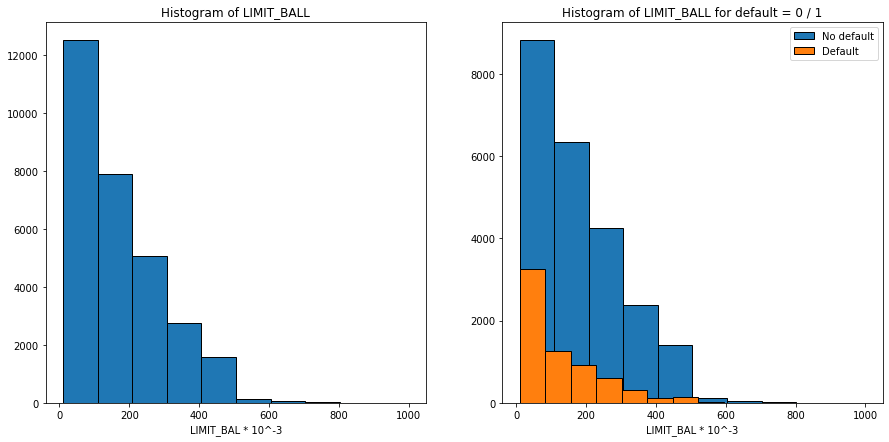

In [38]:
_ = plt.figure(1, figsize=(15,7))

_ = plt.subplot(121)
_ = plt.title('Histogram of LIMIT_BALL')
_ = plt.hist(scores['LIMIT_BAL'] / 1000, edgecolor='k')
_ = plt.xlabel('LIMIT_BAL * 10^-3')

_ = plt.subplot(122)
_ = plt.title('Histogram of LIMIT_BALL for default = 0 / 1')
_ = plt.hist(no_default.LIMIT_BAL / 1000, edgecolor='k', label='No default')
_ = plt.hist(default.LIMIT_BAL / 1000, edgecolor='k', label='Default')
_ = plt.xlabel('LIMIT_BAL * 10^-3')
_ = plt.legend()

## a) интервальная оценка

Построим интервальную оценку методом bootstrap

In [39]:
print("default median: %d" %(default.LIMIT_BAL.median()))
print("no default median: %d" %(no_default.LIMIT_BAL.median()))

default median: 90000
no default median: 150000


$$\text {H0: мединые равны}$$
$$\text {H1: медианы не равны}$$

In [40]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [41]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [42]:
def_median_scores = list(map(np.median, get_bootstrap_samples(default.LIMIT_BAL.values, 1000)))
no_def_median_scores = list(map(np.median, get_bootstrap_samples(no_default.LIMIT_BAL.values, 1000)))

print("95% confidence interval for the default median:",  stat_intervals(def_median_scores, 0.05))
print("95% confidence interval for the no_default median:",  stat_intervals(no_def_median_scores, 0.05))

95% confidence interval for the def_median_scores: [80000. 90000.]
95% confidence interval for the no_def_median_scores: [150000. 150000.]


интервалы не пересекаются

In [43]:
print("difference between medians:", no_default.LIMIT_BAL.median() - default.LIMIT_BAL.median())    

difference between medians: 60000.0


In [44]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(def_median_scores, no_def_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [60000. 70000.]


Гипотеза о равенстве медиан отвергается на уровне 0.05. Различие в медианах практически значимо, так как это различик составляет около половины самих медиан, что, конечно крайне важно.

## b) непараметрический критерий

Воспользуемся перстановочным критерием для независимых выборок

$$\text{H0: распределения равные}$$
$$\text{H1: распределения сдвинуты на }\delta$$

In [45]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [46]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [47]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [48]:
def permutation_test(sample1, sample2, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [50]:
pval = permutation_test(no_default.LIMIT_BAL, default.LIMIT_BAL, max_permutations = 1000)
pval

0.001

гипотеза о равенстве распределений уверенно отвергается на уровне 0.05. Из двух проделанных оценок можем сделать вывод, что люди, не возвращающие кредит, склонны брать меньшие суммы чем те, которые возвращают.

# #2

In [59]:
m_def = default[default.SEX == 1]
m_no_def = no_default[no_default.SEX == 1]

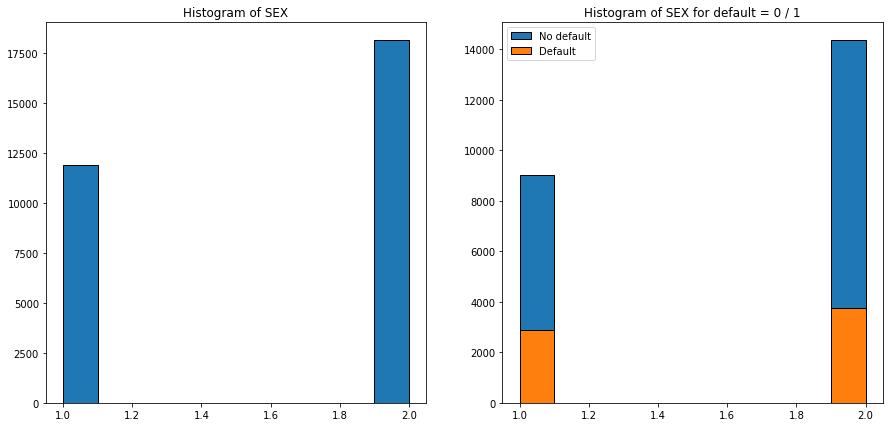

In [57]:
_ = plt.figure(1, figsize=(15,7))

_ = plt.subplot(121)
_ = plt.title('Histogram of SEX')
_ = plt.hist(scores.SEX, edgecolor='k')

_ = plt.subplot(122)
_ = plt.title('Histogram of SEX for default = 0 / 1')
_ = plt.hist(no_default.SEX, edgecolor='k', label='No default')
_ = plt.hist(default.SEX, edgecolor='k', label='Default')
_ = plt.legend()

SEX: пол клиента (1 = мужской, 2 = женский )

In [60]:
print("proportion of men in default group: %.3f" %(len(m_def) / len(default)))
print("proportion of men in no default group: %.3f" %(len(m_no_def) / len(no_default)))

proportion of men in default group: 0.433
proportion of men in no default group: 0.386


## a) интервальная оценка

Воспользуемся z-интервалом для доли. Использовать интервал Уилсона для доли не обязательно, так как доли не близки к 0 или 1

$$\text{H0: гендерный состав группы людей вернувших и не вернувших кредит не отличается}$$
$$\text{H1: отличается}$$

In [61]:
interval_m_def = proportion_confint(len(m_def), len(default), method = 'normal')
interval_m_no_def = proportion_confint(len(m_no_def), len(no_default), method = 'normal')

In [62]:
print("confint for male rate in default group: [%.3f, %.3f] with width %.3f" 
      %(interval_m_def[0], interval_m_def[1], interval_m_def[1] - interval_m_def[0]))
      
print("confint for male rate in no_default group: [%.3f, %.3f] with width %.3f" 
      %(interval_m_no_def[0], interval_m_no_def[1], interval_m_no_def[1] - interval_m_no_def[0]))

confint for male rate in default group: [0.421, 0.445] with width 0.024
confint for male rate in no_default group: [0.380, 0.392] with width 0.012


интервалы не пересекаются

построим доверительный интервал для разности долей

In [63]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = sts.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [65]:
print("men proportion diff in default and no default groups: %.3f" %(len(m_def) / len(default) - len(m_no_def) / len(no_default)))

men proportion diff in default and no default groups: 0.047


In [67]:
print("conf int for men proportion diff in default and no default groups: [%.3f, %.3f]" 
      %(proportions_confint_diff_ind(np.abs(default.SEX - 2), np.abs(no_default.SEX - 2))))

conf int for men proportion diff in default and no default groups: [0.034, 0.061]


Доверительный интервал для разности долей не содержит ноль, следовательно гипотеза о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается, отвергается на уровне 0.05. Данное различие значимо практически, так как 4% для банковской системы это много.

## b) статистический критерий

Воспользуемся Z-критерием для доли двух независимых выборок

$$\text{H0: гендерный состав группы людей вернувших и не вернувших кредит не отличается}$$
$$\text{H1: отличается}$$

In [30]:
p1 = len(m_def) / len(default)
p2 = len(m_no_def) / len(no_default)
n1 = len(default)
n2 = len(no_default)

P = (p1 * n1 + p2 * n2) / (n1 + n2)
Z = (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))

p_value = 2 * (1 - sts.norm.cdf(np.abs(Z)))

p_value

4.472866521609831e-12

гипотеза о равенстве долей мужчин в группах вернувших и не вернувших долг уверенно отвергается на уровне 0.05.

# #3

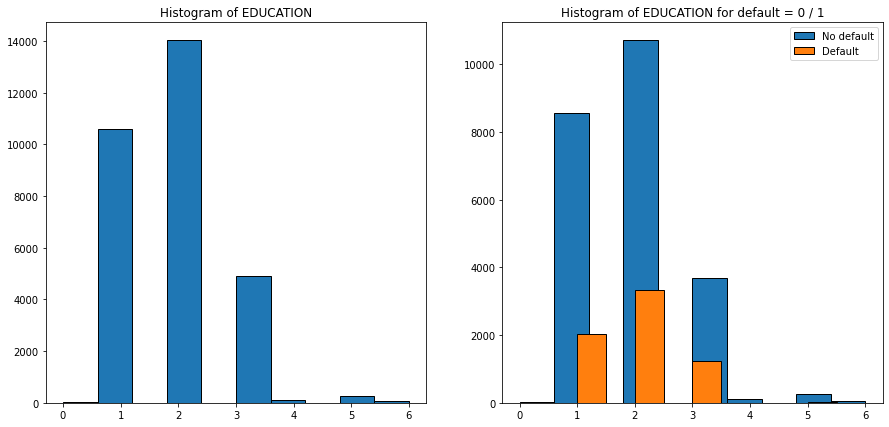

In [70]:
_ = plt.figure(1, figsize=(15,7))

_ = plt.subplot(121)
_ = plt.title('Histogram of EDUCATION')
_ = plt.hist(scores.EDUCATION, edgecolor='k')

_ = plt.subplot(122)
_ = plt.title('Histogram of EDUCATION for default = 0 / 1')
_ = plt.hist(no_default.EDUCATION, edgecolor='k', label='No default')
_ = plt.hist(default.EDUCATION, edgecolor='k', label='Default')
_ = plt.legend()

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

Построим таблицу сопряженности

In [72]:
educ = []
for i in range(7):
    group = scores[scores.EDUCATION == i].default
    educ.append([group.sum(), len(group) - group.sum()])
educ_df = pd.DataFrame(educ, index = ['phd', 'mag', 'bach', 'sch', 'prim', 'other', 'noans'], columns = ['default', 'no_default'])
educ_df

,default,no_default
phd,0,14
mag,2036,8549
bach,3330,10700
sch,1237,3680
prim,7,116
other,18,262
noans,8,43


Воспользуемся критерием ХИ-квадрат. Выборки достаточно велики(кроме phd, которая меньше 40)

$$\text{H0: образование не влияет, вернёт ли человек долг}$$
$$\text{H1: влияет}$$

In [73]:
p_value = sts.chi2_contingency(educ_df)[1]
expected = sts.chi2_contingency(educ_df)[3]

In [74]:
p_value

1.2332626245415605e-32

гипотеза H0 отвергается на уровне 0.05

In [72]:
expected_df = pd.DataFrame(expected, columns = ['default', 'no_default'], index = ['phd', 'mag', 'bach', 'sch', 'prim', 'other', 'noans'])
expected_df

,default,no_default
phd,3.0968,10.9032
mag,2341.4020,8243.5980
bach,3103.4360,10926.5640
sch,1087.6404,3829.3596
prim,27.2076,95.7924
other,61.9360,218.0640
noans,11.2812,39.7188


Заметим, что ожидаемое значение меньше 5 только в одном случае, что нас устраивает

In [73]:
educ_df - expected_df

,default,no_default
phd,-3.0968,3.0968
mag,-305.4020,305.4020
bach,226.5640,-226.5640
sch,149.3596,-149.3596
prim,-20.2076,20.2076
other,-43.9360,43.9360
noans,-3.2812,3.2812


По графе no_default можем понять, что бакалавры и выпускники школ ушли в дефолт чаше, чем ожидалось. Перейдём к относительным величинам, разделив каждую строку на размер образовательной группы

In [74]:
new_educ = []
for i in range(7):
    group = scores[scores.EDUCATION == i].default
    new_educ.append((educ - expected)[i] / len(group))
new_educ_fd = pd.DataFrame(new_educ, 
                           index = ['phd', 'mag', 'bach', 'sch', 'prim', 'other', 'noans'], 
                           columns = ['default', 'no_default'])
new_educ_fd

,default,no_default
phd,-0.221200,0.221200
mag,-0.028852,0.028852
bach,0.016149,-0.016149
sch,0.030376,-0.030376
prim,-0.164289,0.164289
other,-0.156914,0.156914
noans,-0.064337,0.064337


1. Сделать выводы о phd трудно, так как выборка крайне мала, а критерий Хи-квадрат требует объём выборки больше 40. Поэтому рассматривать данную группу не будем.
2. По знаку долей можем сказать, что школьное образование и образование бакалавра является лучшим индикатором того, что человек не отдаст долг, а образование магистра - того, что вернёт.
3. Группы "другое" и "нет ответа" также трудны для интерпретации, так мы не знаем конкретики
4. Отрицательный показатель у бакалвров можно объяснить тем, что у достаточного количества людей остаётся кредит после обучения(особенно если речь идёт о зарубежных странах), который, видимо, не всегда удается погасить. 


# #4

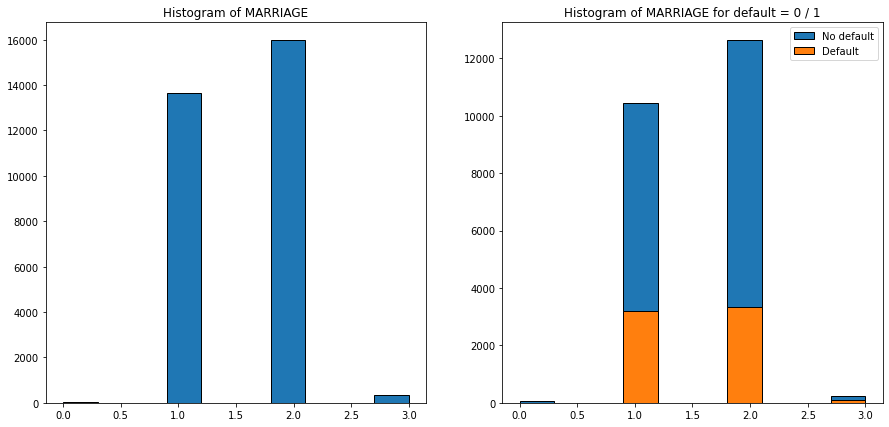

In [80]:
_ = plt.figure(1, figsize=(15,7))

_ = plt.subplot(121)
_ = plt.title('Histogram of MARRIAGE')
_ = plt.hist(scores.MARRIAGE, edgecolor='k')

_ = plt.subplot(122)
_ = plt.title('Histogram of MARRIAGE for default = 0 / 1')
_ = plt.hist(no_default.MARRIAGE, edgecolor='k', label='No default')
_ = plt.hist(default.MARRIAGE, edgecolor='k', label='Default')
_ = plt.legend()

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 

Построим таблицу сопряженности

In [81]:
marr = []
for i in range(4):
    group = scores[scores.MARRIAGE == i].default
    marr.append([group.sum(), len(group) - group.sum()])
marr_df = pd.DataFrame(marr, index = ['reject', 'married', 'single', 'noans'], columns = ['default', 'no_default'])
marr_df

,default,no_default
reject,5,49
married,3206,10453
single,3341,12623
noans,84,239


Воспользуемся критерием хи-квадрат о равенстве нулю коэффициента V-Крамера (все выборки больше 40)

$$\text{H0: коэффициент V-Крамера равен нулю }$$
$$\text{H1: не равен}$$

In [84]:
p_value = sts.chi2_contingency(marr_df)[1]
expected = sts.chi2_contingency(marr_df)[3]
p_value

8.825862457577375e-08

гипотеза H0 отвергается на уровне 0.05

In [89]:
expected_df = pd.DataFrame(expected, index = ['reject', 'married', 'single', 'noans'], columns = ['default', 'no_default'])
expected_df

,default,no_default
reject,11.9448,42.0552
married,3021.3708,10637.6292
single,3531.2368,12432.7632
noans,71.4476,251.5524


ожидаемое значение больше 5 всюду

вычислим коэффициент Крамера

In [84]:
def cramers_stat(confusion_matrix):
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [85]:
cramers_stat(marr_df.values)

0.034478203662766466

Коэффициень V-Крамера очень близок к нулю, из чего можем сделать вывод, что не имеет значения, с каким статусом брака человек берет кредит

# #5

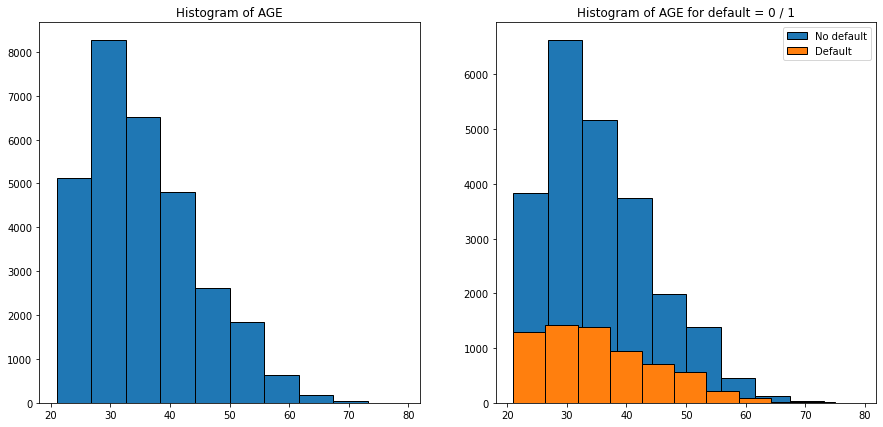

In [86]:
_ = plt.figure(1, figsize=(15,7))

_ = plt.subplot(121)
_ = plt.title('Histogram of AGE')
_ = plt.hist(scores.AGE, edgecolor='k')

_ = plt.subplot(122)
_ = plt.title('Histogram of AGE for default = 0 / 1')
_ = plt.hist(no_default.AGE, edgecolor='k', label='No default')
_ = plt.hist(default.AGE, edgecolor='k', label='Default')
_ = plt.legend()

# a) интервальная оценка

воспользуемся методом bootstrap для проверки гипотезы о равенстве медианных возрастов

$$\text{H0: медианный возраст вернувших и невернувших долг людей одинаков}$$
$$\text{H1: не одинаков}$$

In [94]:
print("default median age: %d" %(default.AGE.median()))
print("no default median age: %d" %(no_default.AGE.median()))

default median age: 34
no default median age: 34


In [95]:
def_median_scores = list(map(np.median, get_bootstrap_samples(default.AGE.values, 1000)))
no_def_median_scores = list(map(np.median, get_bootstrap_samples(no_default.AGE.values, 1000)))

print("95% confidence interval for the def_median_scores:",  stat_intervals(def_median_scores, 0.05))
print("95% confidence interval for the no_def_median_scores:",  stat_intervals(no_def_median_scores, 0.05))

95% confidence interval for the def_median_scores: [34. 35.]
95% confidence interval for the no_def_median_scores: [34. 34.]


интервалы пересекаются

In [98]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(def_median_scores, no_def_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-1.  0.]


Доверительный интервал содержит ноль, значит гипотеза о равенстве медиан не отвергается

# б) параметрический критерий

воспользуемся перестановочным критерием для независимых выборок

$$\text{H0: распределения возрастов в группах вернувших и невернувших долг равны}$$
$$\text{H1: распределения сдвинуты на }\delta$$

In [88]:
pval = permutation_test(no_default.AGE, default.AGE, max_permutations = 10000)
pval

0.0155

гипотеза о равенстве распределений отвергается на уровне 0.05